In [1]:
import sys
sys.path.append("../..")
from IPython.display import display
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import magine.ontology.enrichment_tools as et
from magine.plotting.heatmaps import  heatmap_from_array
from magine.plotting.wordcloud_tools import create_wordcloud
from magine.plotting.venn_diagram_maker import create_venn2
from magine.plotting.species_plotting import plot_list_of_genes

from magine.data.tools import pivot_table
from magine.data.tools import log2_normalize_df

# Visualize enrichment output

Here we load in the results from enrichR

In [2]:
enrichment_array = pd.read_csv('Data/cisplatin_enrichment.csv.gz', index_col=0)

In [3]:
# We can use et.filter_dataframe to select which data to look at

reactome_only = et.filter_dataframe(enrichment_array, 
                                    p_value=0.05, # only sig pvalues
                                    combined_score=0.0, # score threshold of positive values 
                                    db='Reactome_2016', # Only reactome db
                                    category='proteomics_up' # from this category
                                   )

In [4]:
cols = ['term_name', 'combined_score', 'n_genes', 'genes']
display(reactome_only[cols].head(15))

,term_name,combined_score,n_genes,genes
257058,Processing of Capped Intron-Containing Pre-mRN...,116.207435,48,"DDX39B,DHX9,FUS,HNRNPA0,HNRNPA1,HNRNPA2B1,HNRN..."
233500,Processing of Capped Intron-Containing Pre-mRN...,106.902995,46,"CPSF1,CSTF1,CWC15,EFTUD2,EIF4A3,FIP1L1,FUS,HNR..."
233501,Gene Expression_hsa,102.139686,152,"AIMP2,ANP32A,ATF2,ATR,BNIP3L,BOP1,C2ORF49,CD3E..."
257059,mRNA Splicing - Major Pathway_hsa,94.852616,38,"DHX9,FUS,HNRNPA0,HNRNPA1,HNRNPA2B1,HNRNPA3,HNR..."
257060,Gene Expression_hsa,92.138380,147,"ANP32A,APEH,BAZ1B,BDP1,BOP1,CD3EAP,CD44,CDK12,..."
257061,mRNA Splicing_hsa,90.060106,38,"DHX9,FUS,HNRNPA0,HNRNPA1,HNRNPA2B1,HNRNPA3,HNR..."
257062,Metabolism of proteins_hsa,82.654616,108,"APEH,APOA1,ARF4,ATP5A1,ATP5B,CALR,CANX,CD59,CK..."
233502,mRNA Splicing - Major Pathway_hsa,72.889668,33,"CPSF1,CSTF1,CWC15,EFTUD2,EIF4A3,FIP1L1,FUS,HNR..."
233503,mRNA Splicing_hsa,68.905457,33,"CPSF1,CSTF1,CWC15,EFTUD2,EIF4A3,FIP1L1,FUS,HNR..."
233504,Cell Cycle_hsa,62.048920,62,"AKAP9,ATR,BANF1,CEP131,CNTRL,DIDO1,DKC1,DYNC1H..."


In [5]:
# Here we can filter term_names that have very similar gene sets. 
# We use the piccard index and remove the less enriched terms.

reactome_only = et.filter_similar_terms(reactome_only, 
                                        threshold=0.7, 
                                        verbose=False)
display(reactome_only[cols].head(15))

Number of rows went from 574 to 65


,term_name,combined_score,n_genes,genes
233501,Gene Expression_hsa,102.139686,152,"AIMP2,ANP32A,ATF2,ATR,BNIP3L,BOP1,C2ORF49,CD3E..."
257060,Gene Expression_hsa,92.138380,147,"ANP32A,APEH,BAZ1B,BDP1,BOP1,CD3EAP,CD44,CDK12,..."
257062,Metabolism of proteins_hsa,82.654616,108,"APEH,APOA1,ARF4,ATP5A1,ATP5B,CALR,CANX,CD59,CK..."
233504,Cell Cycle_hsa,62.048920,62,"AKAP9,ATR,BANF1,CEP131,CNTRL,DIDO1,DKC1,DYNC1H..."
257063,Disease_hsa,56.883870,71,"ALB,AP2B1,APC,BAD,BANF1,CALR,CANX,CD9,CHMP7,CT..."
257064,Formation of ATP by chemiosmotic coupling_hsa,56.683867,11,"ATP5A1,ATP5B,ATP5C1,ATP5D,ATP5F1,ATP5H,ATP5I,A..."
210798,Gene Expression_hsa,55.510780,91,"AEBP2,ANP32A,ATF2,ATR,BMS1,BOP1,CPSF2,CPSF3,DA..."
257065,Hemostasis_hsa,52.388225,60,"ACTN1,ACTN4,AHSG,ALB,ALDOA,APOA1,APOH,ATP1B1,B..."
257066,Vesicle-mediated transport_hsa,50.489896,55,"ALB,APOA1,APOE,ARF4,CALR,CD59,CHMP7,COPA,COPG2..."
257067,The citric acid (TCA) cycle and respiratory el...,49.572454,29,"ATP5A1,ATP5B,ATP5C1,ATP5D,ATP5F1,ATP5H,ATP5I,A..."


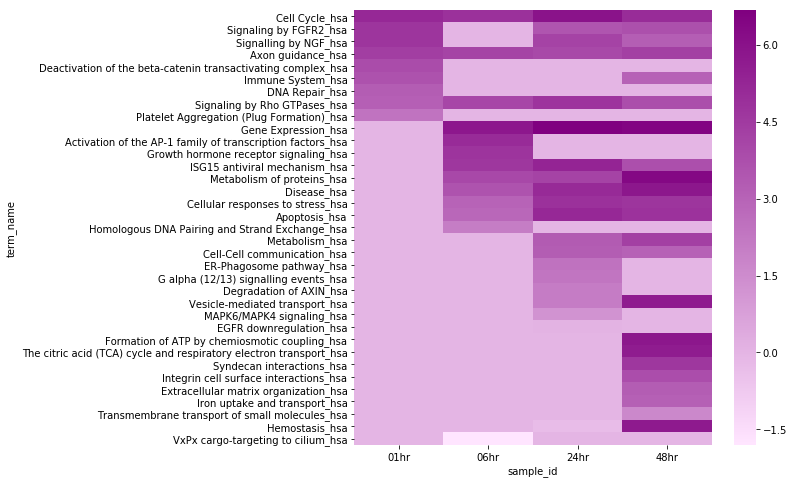

In [6]:
fig = heatmap_from_array(reactome_only,
                         convert_to_log=True,
                         fig_size=(8, 8))

fig.savefig('enrichment.png', dpi=300, bbox_inches='tight')

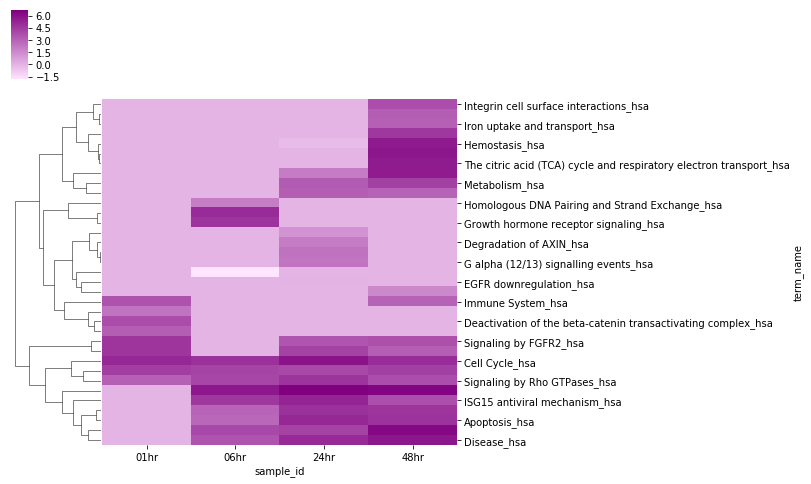

In [7]:

fig = heatmap_from_array(reactome_only, 
                         convert_to_log=True, 
                         cluster_col=False, 
                         cluster_row=True, 
                         fig_size=(8, 8))

fig.savefig('cluster_enrichment.png', dpi=300, bbox_inches='tight')

In [8]:
# lets define a subset of all possible databases to look at.
process_dbs = [
        'GO_Biological_Process_2017',
        'Humancyc_2016',
        'Reactome_2016',
        'KEGG_2016',
        'NCI-Nature_2016',
        'Panther_2016',
        'WikiPathways_2016',
]

drug_dbs = ['DrugMatrix', 'Drug_Perturbations_from_GEO_2014']

In [9]:
drug_df = et.filter_dataframe(enrichment_array, 
                              p_value=0.05,
                              combined_score=0.0,
                              rank=25,
                              db=drug_dbs)
print(drug_df.shape)

(723, 9)


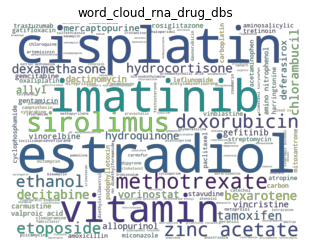

In [10]:
wordcloud_drugs = create_wordcloud(drug_df)
wordcloud_drugs.plot(save_name='word_cloud_rna_drug_dbs')

In [11]:
sig_array = et.filter_dataframe(enrichment_array,
                                p_value=0.05, 
                                combined_score=5.0, 
                                rank=25,
                                db=process_dbs
                               )
print(sig_array.shape)
display(sig_array.head(10))

(1726, 9)


,term_name,rank,combined_score,adj_p_value,genes,n_genes,sample_id,category,db
166954,SRP-dependent cotranslational protein targetin...,1,730.868622,2.468246e-75,"RPL10,RPL10A,RPL11,RPL12,RPL13,RPL13A,RPL15,RP...",72,48hr,proteomics_down,GO_Biological_Process_2017
74510,SRP-dependent cotranslational protein targetin...,1,603.684107,1.164942e-61,"RPL10,RPL10A,RPL11,RPL12,RPL13,RPL13A,RPL15,RP...",74,48hr,proteomics_both,GO_Biological_Process_2017
166955,"nuclear-transcribed mRNA catabolic process, no...",2,597.367982,9.922860e-62,"CASC3,PPP2R1A,PPP2R2A,PYM1,RPL10,RPL10A,RPL11,...",71,48hr,proteomics_down,GO_Biological_Process_2017
74511,"nuclear-transcribed mRNA catabolic process, no...",2,546.358008,3.720681e-56,"CASC3,MAGOHB,NCBP1,PPP2CA,PPP2R1A,PPP2R2A,PYM1...",79,48hr,proteomics_both,GO_Biological_Process_2017
143398,SRP-dependent cotranslational protein targetin...,1,501.755701,5.862704e-51,"RPL10,RPL11,RPL12,RPL13,RPL13A,RPL14,RPL17,RPL...",56,24hr,proteomics_down,GO_Biological_Process_2017
143399,"nuclear-transcribed mRNA catabolic process, no...",2,466.170447,9.449129e-48,"CASC3,DCP1A,EIF3E,EIF4G1,RPL10,RPL11,RPL12,RPL...",59,24hr,proteomics_down,GO_Biological_Process_2017
166956,translational initiation,3,428.244730,1.258290e-60,"EIF2S3,EIF3H,EIF4A2,EIF5,LARP1,RPL10,RPL10A,RP...",71,48hr,proteomics_down,GO_Biological_Process_2017
166957,viral transcription,4,425.237579,7.640183e-63,"NUP160,NUP214,NUP85,NUP88,RANBP2,RPL10,RPL10A,...",71,48hr,proteomics_down,GO_Biological_Process_2017
166958,rRNA processing,5,393.991452,4.352375e-48,"BYSL,DDX56,LTV1,NOB1,NOLC1,PDCD11,RPL10,RPL10A...",76,48hr,proteomics_down,GO_Biological_Process_2017
74512,rRNA processing,3,388.128659,3.248782e-47,"BOP1,BYSL,DDX56,DKC1,FBL,LTV1,NOB1,NOL11,NOLC1...",92,48hr,proteomics_both,GO_Biological_Process_2017


In [12]:
sig_array = et.filter_similar_terms(sig_array, threshold=0.7)

Number of rows went from 1726 to 1064


Number of rows went from 363 to 263


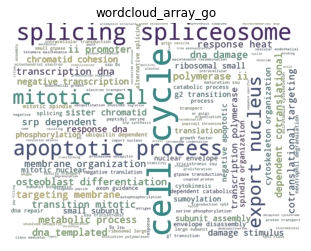

In [13]:
sig_array = et.filter_dataframe(enrichment_array,
                                p_value=0.05, 
                                combined_score=5.0, 
                                rank=25,
                                db='GO_Biological_Process_2017'
                               )
sig_array = et.filter_similar_terms(sig_array, threshold=0.7)
wordcloud = create_wordcloud(sig_array)
wordcloud.plot(save_name='wordcloud_array_go')

Number of rows went from 278 to 258


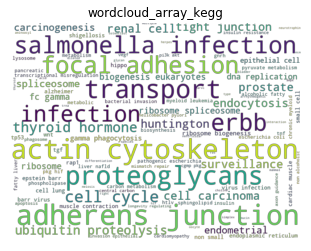

In [14]:
sig_array = et.filter_dataframe(enrichment_array,
                                p_value=0.05, 
                                combined_score=5.0, 
                                rank=25,
                                db='KEGG_2016'
                               )
sig_array = et.filter_similar_terms(sig_array, threshold=0.7)
wordcloud = create_wordcloud(sig_array)
wordcloud.plot(save_name='wordcloud_array_kegg')

Number of rows went from 351 to 282


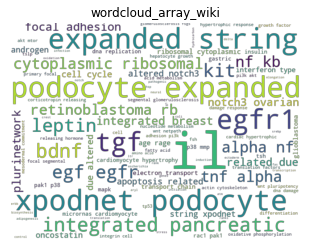

In [15]:
sig_array = et.filter_dataframe(enrichment_array,
                                p_value=0.05, 
                                combined_score=5.0, 
                                rank=25,
                                db='WikiPathways_2016'
                               )
sig_array = et.filter_similar_terms(sig_array, threshold=0.7)
wordcloud = create_wordcloud(sig_array)
wordcloud.plot(save_name='wordcloud_array_wiki')

Number of rows went from 282 to 282


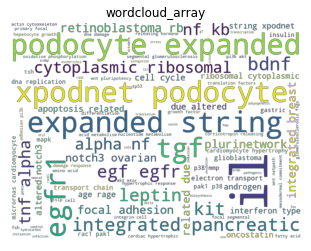

In [16]:
sig_array = et.filter_similar_terms(sig_array, threshold=0.7)
wordcloud = create_wordcloud(sig_array)
wordcloud.plot(save_name='wordcloud_array')

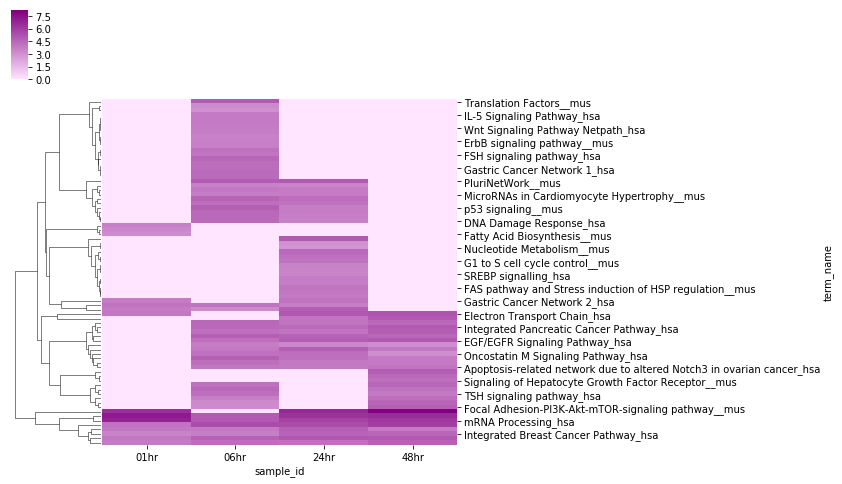

In [17]:
fig = heatmap_from_array(sig_array, 
                         convert_to_log=True, 
                         cluster_col=False, 
                         cluster_row=True, 
                         fig_size=(8, 8))

fig.savefig('enrichment_example3.png', dpi=300, bbox_inches='tight')